#### To build a hybrid anomaly detection model using a sparse autoencoder, Isolation Forest, and XGBoost, follow these steps: First, load and clean your data to ensure it is accurate and relevant. Next, select key features and split the dataset into training and testing sets. Normalize the features through scaling to ensure they are equally weighted. Use a sparse autoencoder to reduce the dimensionality of the data, facilitating more efficient processing. Apply an Isolation Forest to initially identify and isolate potential anomalies. Further refine this detection with XGBoost, enhancing the model's accuracy, especially for subtle anomalies. Finally, evaluate the model using precision, recall, F1-score, and a confusion matrix to assess its overall performance and accuracy. This sequential approach leverages each method's strengths to create a robust and effective anomaly detection system.

In [4]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from xgboost import XGBClassifier
from sklearn.ensemble import IsolationForest
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras import regularizers
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, confusion_matrix

Epoch 1/50
191/191 [==============================] - 1s 2ms/step - loss: 497.1012
Epoch 2/50
191/191 [==============================] - 0s 1ms/step - loss: 492.4990
Epoch 3/50
191/191 [==============================] - 0s 1ms/step - loss: 490.7113
Epoch 4/50
191/191 [==============================] - 0s 1ms/step - loss: 490.7065
Epoch 5/50
191/191 [==============================] - 0s 1ms/step - loss: 490.6964
Epoch 6/50
191/191 [==============================] - 0s 998us/step - loss: 490.6867
Epoch 7/50
191/191 [==============================] - 0s 1ms/step - loss: 490.6807
Epoch 8/50
191/191 [==============================] - 0s 1ms/step - loss: 490.6772
Epoch 9/50
191/191 [==============================] - 0s 1ms/step - loss: 490.6747
Epoch 10/50
191/191 [==============================] - 0s 1ms/step - loss: 490.6730
Epoch 11/50
191/191 [==============================] - 0s 1ms/step - loss: 490.6717
Epoch 12/50
191/191 [==============================] - 0s 1ms/step - loss: 490.6706

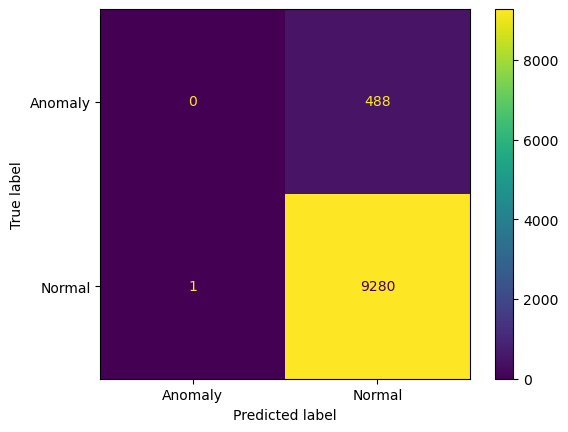

In [10]:

def hybrid_anomaly_detection():
    # Load and preprocess the dataset
    data = pd.read_csv('adultdata.csv')
    
    data.dropna(axis=0, inplace=True)
    #convert all the values in the columns into numeric
    label_encoder = LabelEncoder()
    for column in data.select_dtypes(include=['object']).columns:
        data[column] = label_encoder.fit_transform(data[column])
    
    data = data.drop('Sex', axis=1)
    
    X = data.drop('fnlwgt', axis=1)  # This is the 'target' variable
    y_cont = data['fnlwgt']
    
    y = np.where(y_cont > 40000, 1, 0)  # Define `threshold` based on the dataset
    
    # Select top k features; k might be adjusted based on the dataset
    selector = SelectKBest(f_classif, k=10)
    X_selected = selector.fit_transform(X, y)
    
    #data.info()
    
    # Dimensionality reduction with sparse autoencoder
    input_dim = X_selected.shape[1]
    encoding_dim = 32
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(encoding_dim, activation='relu', activity_regularizer=regularizers.l1(10e-5))(input_layer)
    decoded = Dense(input_dim, activation='sigmoid')(encoded)
    autoencoder = Model(input_layer, decoded)
    autoencoder.compile(optimizer='adam', loss='mean_squared_error')
    autoencoder.fit(X_selected, X_selected, epochs=50, batch_size=256, shuffle=True)
    
    encoder = Model(input_layer, encoded)
    X_encoded = encoder.predict(X_selected)
    
    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Use Isolation Forest to identify normal data points
    iso_forest = IsolationForest(contamination=0.1, random_state=42)
    iso_forest.fit(X_train_scaled)
    iso_preds = iso_forest.predict(X_train_scaled)
    
    # Filter only normal data points as identified by Isolation Forest
    normal_indices = np.where(iso_preds == 1)[0]
    X_train_normal = X_train_scaled[normal_indices]
    y_train_normal = y_train[normal_indices]
    
    # Train XGBoost on the filtered normal data
    xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
    xgb.fit(X_train_normal, y_train_normal)
    
    # Predict and evaluate the model on the test set
    y_pred = xgb.predict(X_test_scaled)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    
    print(f'Precision: {precision:.3f}, Recall: {recall:.3f}, F1 Score: {f1:.3f}')
    
    print(classification_report(y_test, y_pred))
    
    # Visualize the outcome with a confusion matrix

    
    cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Anomaly', 'Normal'])
    disp.plot()
    plt.show()


hybrid_anomaly_detection()